<a href="https://colab.research.google.com/github/sejin-sim/Practical_statistics/blob/main/2_%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%99%80_%ED%91%9C%EB%B3%B8%EB%B6%84%ED%8F%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 셋팅

In [1]:
! pip install wquantiles 

%matplotlib inline

from pathlib import Path
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.utils import resample

import seaborn as sns
import matplotlib.pylab as plt

! git clone https://github.com/gedeck/practical-statistics-for-data-scientists.git
! cp -r /content/practical-statistics-for-data-scientists/data /content/data

try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

AIRLINE_STATS_CSV = DATA / 'airline_stats.csv'
KC_TAX_CSV = DATA / 'kc_tax.csv.gz'
LC_LOANS_CSV = DATA / 'lc_loans.csv'
AIRPORT_DELAYS_CSV = DATA / 'dfw_airline.csv'
SP500_DATA_CSV = DATA / 'sp500_data.csv.gz'
SP500_SECTORS_CSV = DATA / 'sp500_sectors.csv'
STATE_CSV = DATA / 'state.csv'

Cloning into 'practical-statistics-for-data-scientists'...
remote: Enumerating objects: 363, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 363 (delta 75), reused 93 (delta 27), pack-reused 207
Receiving objects: 100% (363/363), 83.68 MiB | 13.09 MiB/s, done.
Resolving deltas: 100% (161/161), done.


# 1. 표본추출

- 용어 정리
 - 표본(sample) : 더 큰 데이터 집합으로부터 얻은 부분집합
 - 모집단(population) : 어떤 데이터 집합을 구성하는 전체 대사 혹은 전체 집합
 - N(n) : 모집단(표본)의 크기
 - 임의표본추출(임의표집, 랜덤표본추출=random sampling) : 무작위로 표본을 추출하는 것
 - 층화표본추출(층화표집=strafifued sampling) : 모집단을 층으로 나눈 뒤, 각 층에서 무작위로 표본을 추출하는 것
 - 계층(stratum) : 공통된 특징을 가진 모집단이ㅡ 동종 하위 그룹
 - 단순임의표본(단순랜덤표본=simple random sample) : 모집단 층화 없이 임의표본추출로 얻은 표본
 - 편향(bias) : 통계상의 오류
 - 표본편향(sample bias) : 모집단을 잘못 대표하는 표본 

1. 모집단의 표본 평균 = $\bar{x}$ = ex. 50개 주에서 추출한 샘플로부터 각각 구한 평균 값
2. 모집단의 평균(=모평균) = $\mu$ = 표본평균의 평균

# 2. 편향

- 용어 정리
 - 선택편향(selection bias) : 관측 데이터를 선택하는 방식 때문에 생기는 편향
 - 데이터 스누핑(data snooping) : 뭔가 흥미로운 것을 찾아 광범위하게 데이터를 살피는 것
 - 방대한 검색 효과(vaset search effect) : 중복 데이터 모델링이나 너무 많은 예측변수를 고려하는 모델링에서 비롯되는 편향 혹은 비재현성

- 가설을 구체적으로 명시하고 임의표본 추출원칙에 따라 데이터 수집시 편향을 피할 수 있다.
- 모든 데이터 분석은 편향의 위험성(데이터 스누핑, 흥미로운 사건의 사후 선택 등)을 늘 갖고 있다.


# 3. 통계학에서의 표본 분포
- 표본분포 : 하나의 동일한 모집단에서 얻은 여러 샘플에 대한 표본통계량의 분포
- 표본통계량의 분포는 데이터 분포보다 규칙적이고 종 모양일 가능성이 높다.

- 예시 : 대출 신청자 연간 소득 정보

In [2]:
LOANS_INCOME_CSV = DATA / 'loans_income.csv'
SP500_DATA_CSV = DATA / 'sp500_data.csv.gz'

In [3]:
loans_income = pd.read_csv(LOANS_INCOME_CSV, squeeze=True)

# 5만개 중에 천개
sample_data = pd.DataFrame({
    'income': loans_income.sample(1000),
    'type': 'Data',
})

# 5만개 중에 5개씩씩 묶어서 평균 낸게 천개
sample_mean_05 = pd.DataFrame({
    'income': [loans_income.sample(5).mean() for _ in range(1000)],
    'type': 'Mean of 5',
})

# 5만개 중에 20개씩 묶어서 평균 낸게 천개
sample_mean_20 = pd.DataFrame({
    'income': [loans_income.sample(20).mean() for _ in range(1000)],
    'type': 'Mean of 20',
})

results = pd.concat([sample_data, sample_mean_05, sample_mean_20])
print(results.head())

        income  type
38115  97000.0  Data
13271  30000.0  Data
31859  75000.0  Data
33566  92000.0  Data
14535  55000.0  Data


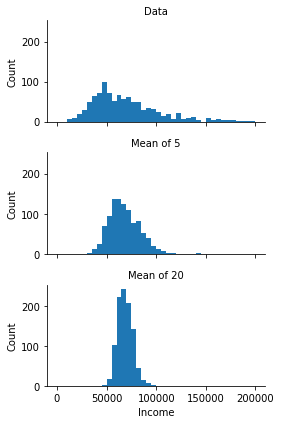

In [4]:
g = sns.FacetGrid(results, col='type', col_wrap=1, 
                  height=2, aspect=2)
g.map(plt.hist, 'income', range=[0, 200000], bins=40)
g.set_axis_labels('Income', 'Count')
g.set_titles('{col_name}')

plt.tight_layout()
plt.show()

- 맨 위 : 1000명의 연간 소득
- 중간 : n=5 일 때, 1,000개의 평균
- 맨 아래 : n=20 일 때, 1,000개의 평균

<br> 

1. 중심극한정리 : 여러 표본에서 추출한 평균은 종모양의 정규곡선을 따름 (ex. n=20 히스토그램)


2. 표준오차 : 표본분포의 변동성(=표본통계량)을 요약하는 주요 측정 지표
## $ 표준오차= SE = \frac{s}{\sqrt{n}} $
 - 표본값들의 표준편차(=s)와 표본크기(=n)을 기반으로 한 통계량을 이용하여 추정
 - 표본크기(=s) ↑ → 표준오차 ↓
 - 표준오차(SE)와 표본크기(n)의 사이 관계 = n 제곱근의 법칙



# 4. 부트스트랩
- 부트스트랩 : 현재 표본에서 추가 표본을 복원추출하고 각 표본에 대한 통계량과 모델을 다시 계산하는 절차(= 원래 표본을 여러번 복제)

 → 원래 표본으로부터 얻어지는 모든 정보를 포함하는 가상 모집단을 얻게 됨

- 부트스트랩 재표본추출 알고리즘
 1. 샘플 값을 하나 뽑아서 기록하고 제자리에 놓는다.
 2. n번 반복한다.
 3. 재표본추출된 값의 평균을 기록한다.
 4. 1~3단계를 R번(임의 설정) 반복한다.
 5. R개의 결과를 사용하여
> 1. 그것들의 표준편차(표본평균의 표준오차)를 계산한다.
> 2. 히스토그램 또는 상자그림을 그린다.
> 3. 신뢰구간을 찾는다.

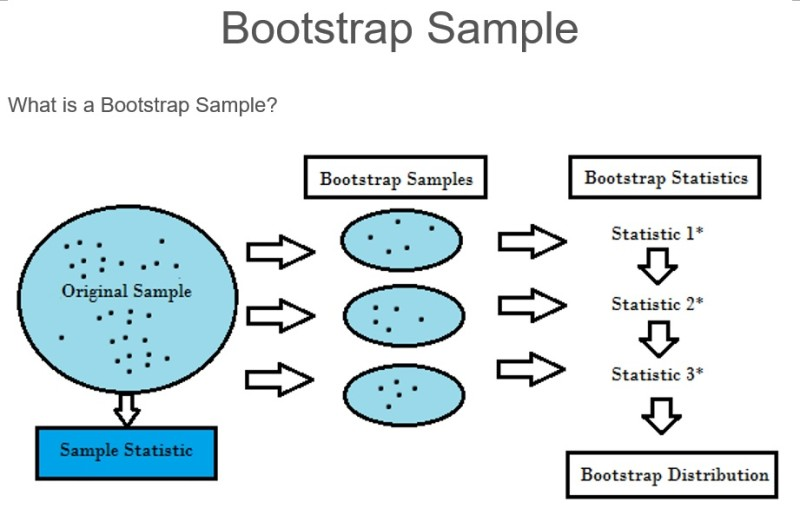

In [5]:
results = []
for nrepeat in range(1000):
    sample = resample(loans_income)
    results.append(sample.median())
results = pd.Series(results)
print('Bootstrap Statistics:')
print(f'original(중간값의 원래 추정치): {loans_income.median()}')
print(f'bias(편향): {results.mean() - loans_income.median()}')
print(f'std. error(표준오차): {results.std()}')

Bootstrap Statistics:
original(중간값의 원래 추정치): 62000.0
bias(편향): -82.70100000000093
std. error(표준오차): 227.25531143534653


- 여러 부트스트랩 샘플을 가지고 트리를 여러개 만든 다음 각 트리에서 나온 예측값을 평균으로 내는 것 = 배깅(=의사 결정 트리)

# 5. 신뢰구간

- 신뢰구간 : 표본 통계량의 부트스트랩 표본분포의 ##%(ex.90, 95%)를 포함하는 구간을 말함

- 부트스트랩 신뢰구간을 구하는 법
 1. 데이터에서 복원추출 방식으로 크기 n인 표본을 뽑는다(재표본추출).
 2. 재표본추출한 표본에 대해 원하는 통계량을 기록한다.
 3. 1~2단계를 R번 반복한다.
 4. x% 신뢰구간을 구하기 위해, R개의 재표본 결과로부터 분포의 양쪽 끝에서 [(100 - x) / 2]% 만큼 잘라낸다.
 5. 절단한 점들은 x% 부트스트랩 신뢰구간의 양 끝점이다.


- 구간 끝점(interval endpoint): 신뢰구간의 최상위, 최하위 끝점

- 예제 : 20명 표본인 대출 신청자의 연간소득에 대한 부트스트랩 신뢰구간

68760.51844
55734.1


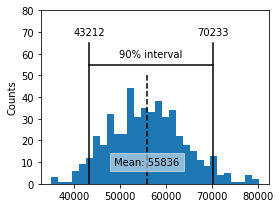

In [6]:
print(loans_income.mean())
np.random.seed(seed=3)  
# create a sample of 20 loan income data
sample20 = resample(loans_income, n_samples=20, replace=False)
print(sample20.mean())
results = []
for nrepeat in range(500):
    sample = resample(sample20)
    results.append(sample.mean())
results = pd.Series(results)

confidence_interval = list(results.quantile([0.05, 0.95]))
ax = results.plot.hist(bins=30, figsize=(4, 3))
ax.plot(confidence_interval, [55, 55], color='black')
for x in confidence_interval:
    ax.plot([x, x], [0, 65], color='black')
    ax.text(x, 70, f'{x:.0f}', 
            horizontalalignment='center', verticalalignment='center')
ax.text(sum(confidence_interval) / 2, 60, '90% interval',
        horizontalalignment='center', verticalalignment='center')

meanIncome = results.mean()
ax.plot([meanIncome, meanIncome], [0, 50], color='black', linestyle='--')
ax.text(meanIncome, 10, f'Mean: {meanIncome:.0f}',
        bbox=dict(facecolor='white', edgecolor='white', alpha=0.5),
        horizontalalignment='center', verticalalignment='center')
ax.set_ylim(0, 80)
ax.set_ylabel('Counts')

plt.tight_layout()
plt.show()

- 90%의 신뢰구간, 평균 55.734달러

# 6. 정규분포(normal distribution)

- 표준정규분포 : x축 단위가 평균의 표준편차로 표현되는 정규 분포(평균이 0이고, 표준편차가 1)
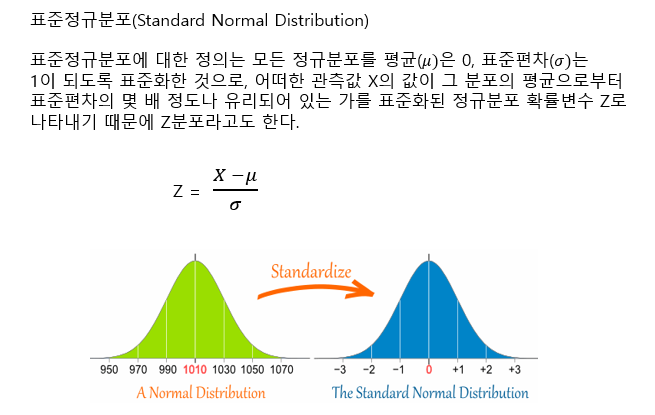

- 정규화(=표준화) : 데이터에서 평균을 뺀 다음 표준편차로 나눔 → z 점수

- 예제 : 표준정규분포로부터 추출한 100개 표본의 QQ그림(표본분포가 특정 분포에 얼마나 가까운지 보여줌)

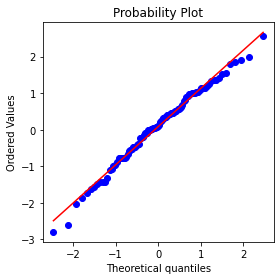

In [7]:
fig, ax = plt.subplots(figsize=(4, 4))

norm_sample = stats.norm.rvs(size=100)
stats.probplot(norm_sample, plot=ax)

plt.tight_layout()
plt.show()

- 정규분포에서 임의로 생성한 100개의 값
- 점들이 대각선에 가깝게 따라가며, 이는 표본분포가 정규분포에 가까운 것으로 간주 가능

# 7. 긴 꼬리 분포

- 데이터는 일반적으로 정규분포를 따르지 않음 → 긴 꼬리(=적은 수의 극단 값이 존재하는)를 가질 수 있음

- 정규분포를 따른다는 가정은 '흑고니 이론'에 대한 과소평가를 가져올 수 있음

- 예제 : 넷플릭스의 일일 주식 수익률 QQ그림

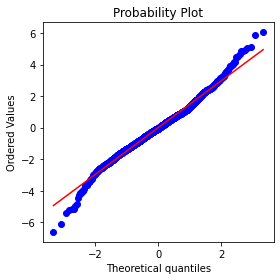

In [8]:
sp500_px = pd.read_csv(SP500_DATA_CSV)

nflx = sp500_px.NFLX
nflx = np.diff(np.log(nflx[nflx>0]))

fig, ax = plt.subplots(figsize=(4, 4))
stats.probplot(nflx, plot=ax)

plt.tight_layout()
plt.show()

- 정규분포 그래프와 비교 시, 대각선 보다 훨씬 낲고 높은 선에 점들이 위치해 있음 = 정규분포를 따르지 않음

# 8. 스튜던트의 t분포(t-distribution)

- t분포 : 정규분포와 생김새가 비슷하지만, 꼬리 부분이 약간 더 두껍고 김

- t분포는 표본평균, 두 표본평균 사이의 차이, 회구 파라미터 등의 분포를 위한 기준으로 널리 사용됨

- 자유도 : 다른 표본크기, 통계량, 그룹의 수에 따라 t분포를 조절하는 변수

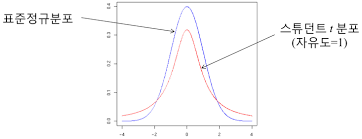

# 9. 이항분포(binomial distribution)

- 이항분포 : 각 시행마다 그 성공 확률($p$)이 정해져 있을 때, 주어진 시행(=하나의 사건) 횟수($n$) 중에서 성공한 횟수($x$)의 도수 분포를 의미

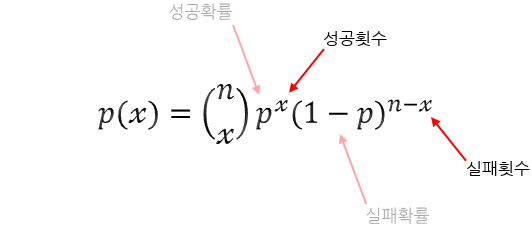

- n이 크고 p가 0 또는 1에 너무 가깝지 않은 경우(=0.5에 가까울 때), 이항분포는 정규분포로 근사할 수 있다.

- ex) 한 번의 클릭이 판매로 이어질 확률이 0.02일 때, 200회 클릭으로 0회 매출을 관찰할 확률은? 

In [13]:
print(stats.binom.pmf(0, n=200, p=0.02))

0.017587946605721567


In [14]:
print(stats.binom.cdf(0, n=200, p=0.02))

0.0175879466057215


# 10. 카이제곱분포(chi-squared distribution)

- 카이제곱(=$x^2$)분포 : k개의 서로 독립적인 표준정규 확률변수를 각각 제곱한 다음 합해서 얻어지는 분포

 = 분산의 특징을 확률분포로 만든 것

- 카이제곱통계는 귀무 모델의 기댓값에서 벗어난 정도를 측정

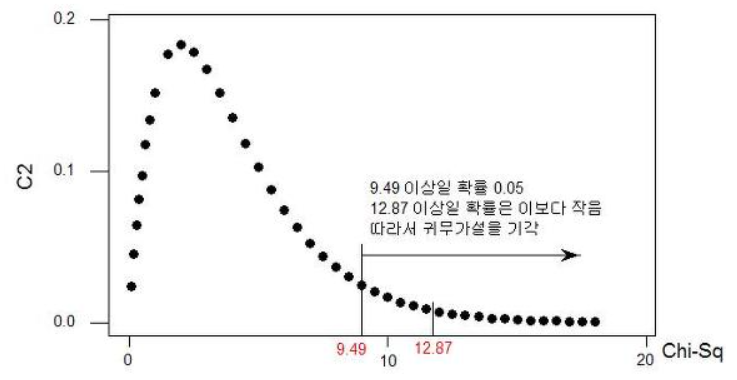

# 11. F분포

- F분포 : 나눗셈을 이용하여 두 집단의 분산을 다룬다

- ANOVA : 2개 이상인 집단을 다룰 때

- F통계량은 관심 요인으로 인한 변동성과 전체 변동성을 비교한다.

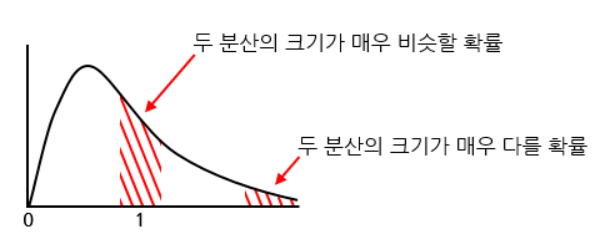

# 12. 푸아송 분포(Poisson distribution)

- 푸아송 분포(Poisson distribution) : 표집된 단위 시간 혹은 단위 공간에서 발생한 사건의 도수 분포

- ex) 5초 동안 서버에 도착한 인터넷 트래픽을 95%의 확률로 완벽하게 처리하는데 필요한 용량은 얼마일까?

- 주요 포인트 : λ(= 어떤 일정 시간/공간의 구간 안에서 발생한 평균 사건 수)



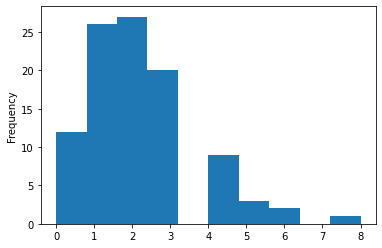

In [15]:
sample = stats.poisson.rvs(2, size=100)

pd.Series(sample).plot.hist()
plt.show()

- 람다가 2인 푸아송 분포에서 난수 100개 생성 

 = cs센터에서 1분당 평균 2회로 문의 전화가 접수 될때 100분을 시뮬레이션하여 100분당 문의 전화한 횟수

# 13. 지수분포(exponential distribution)

- 지수분포(exponential distribution) : 한 사건에서 그 다음 사건까지의 시간이나 거리에 대한 도수분포

- n(난수 발생 개수)와 비율(시간 주기당 사건 수)를 사용



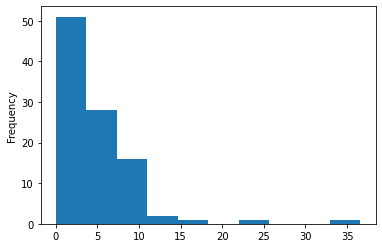

In [17]:
sample = stats.expon.rvs(scale=1/0.2, size=100)

pd.Series(sample).plot.hist()
plt.show()

- 평균 사건 수가 0.2인 지수분포에서 난수 100개를 생성

 = 분당 평균 0.2회 서비스 문의 전화가 걸려오는 경우, 100분 동안의 서비스 센터 문의 전화를 시뮬레이션 가능

- 푸아송이나 지수분포는 λ가 해당 기간 동안 일정하게 유지된다는 가정 → 아니라면 베이불 분포

# 14. 베이불 분포(Weibull distribution) 

- 베이불 분포(Weibull distribution) : 사건 발생률이 시간에 따라 변화하는, 지수분포의 일반화된 버전

- 발생률 β(형상 파라미터) : β > 1 발생률은 시간에 지남에 따라 증가,  β < 1 이면 감소

- 척도 η : 구간당 특성 수명


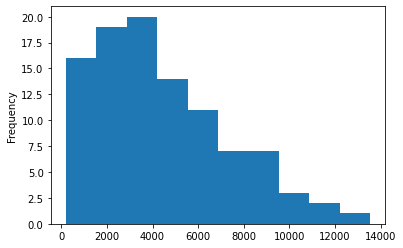

In [18]:
sample = stats.weibull_min.rvs(1.5, scale=5000, size=100)

pd.Series(sample).plot.hist()
plt.show()

- 1.5의 형상 파라미터와 5,000의 특성 수정을 갖는 베이불 분포에서 난수 100개를 생성